In [1]:
import os
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

In [2]:
csvs = sorted(glob.glob("data/*.csv"))
if not csvs:
    raise FileNotFoundError("No CSV found in data/. Put your dataset CSV(s) in the data/ folder.")

if len(csvs) == 1:
    DATA_PATH = csvs[0]
    df = pd.read_csv(DATA_PATH)
else:
    # Merge all CSVs found
    parts = [pd.read_csv(p) for p in csvs]
    df = pd.concat(parts, ignore_index=True)
    # Save a unified file for consistency
    DATA_PATH = "data/transactions.csv"
    df.to_csv(DATA_PATH, index=False)

print("Rows, Cols:", df.shape)
df.head()

Rows, Cols: (555719, 23)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [3]:
TARGET_CANDIDATES = ["is_fraud", "Class", "isFraud", "Fraud", "label"]

target = next((c for c in TARGET_CANDIDATES if c in df.columns), None)
if target is None:
    raise ValueError(f"Target column not found. Available: {list(df.columns)}")


N = 200_000  # try 200k rows for faster training on a laptop; set to None for all data
if N is not None and len(df) > N:
    df = df.sample(n=N, random_state=42).reset_index(drop=True)

y = df[target].astype(int)
X = df.drop(columns=[target])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

len(df), target, len(num_cols), len(cat_cols)

(200000, 'is_fraud', 10, 12)

In [4]:
def build_pipelines(num_cols, cat_cols, use_smote=False):
    pre = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ])
    lr = LogisticRegression(max_iter=3000, class_weight="balanced")
    rf = RandomForestClassifier(
        n_estimators=300, class_weight="balanced_subsample",
        random_state=42, n_jobs=-1
    )
    if use_smote:
        lr_pipe = ImbPipeline([("pre", pre), ("smote", SMOTE(random_state=42)), ("clf", lr)])
        rf_pipe = ImbPipeline([("pre", pre), ("smote", SMOTE(random_state=42)), ("clf", rf)])
    else:
        lr_pipe = Pipeline([("pre", pre), ("clf", lr)])
        rf_pipe = Pipeline([("pre", pre), ("clf", rf)])
    return {"logreg": lr_pipe, "rf": rf_pipe}

def evaluate_model(model, X_test, y_test):
    proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    return (
        roc_auc_score(y_test, proba),
        average_precision_score(y_test, proba),
        classification_report(y_test, y_pred, zero_division=0),
        confusion_matrix(y_test, y_pred),
        proba
    )

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

models = build_pipelines(num_cols, cat_cols, use_smote=False)
best_model, best_name, best_pr_auc, best_proba = None, None, -1, None

for name, m in models.items():
    m.fit(X_train, y_train)
    roc, pr, report, cm, proba = evaluate_model(m, X_test, y_test)
    print(f"{name}: ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")
    if pr > best_pr_auc:
        best_pr_auc, best_model, best_name, best_proba = pr, m, name, proba

# Optional: try SMOTE variants too
models_smote = build_pipelines(num_cols, cat_cols, use_smote=True)
for name, m in models_smote.items():
    m.fit(X_train, y_train)
    roc, pr, report, cm, proba = evaluate_mi8iiiikodel(m, X_test, y_test)
    print(f"{name}_smote: ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")
    if pr > best_pr_auc:
        best_pr_auc, best_model, best_name, best_proba = pr, m, name + "_smote", proba

print("\nBest model:", best_name, "PR-AUC:", round(best_pr_auc, 4))

logreg: ROC-AUC=0.9608 | PR-AUC=0.2803
rf: ROC-AUC=0.9842 | PR-AUC=0.6932
logreg_smote: ROC-AUC=0.9536 | PR-AUC=0.2707
rf_smote: ROC-AUC=0.9895 | PR-AUC=0.6369

Best model: rf PR-AUC: 0.6932


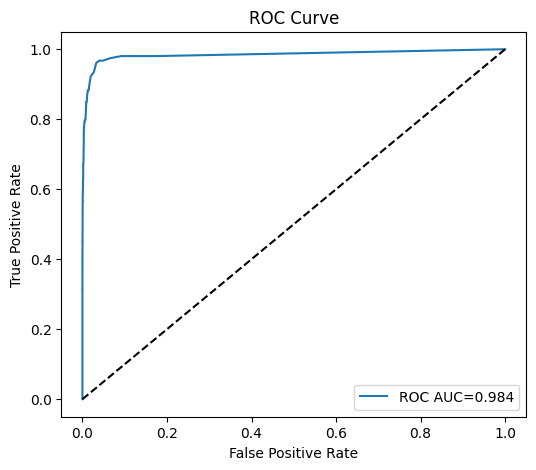

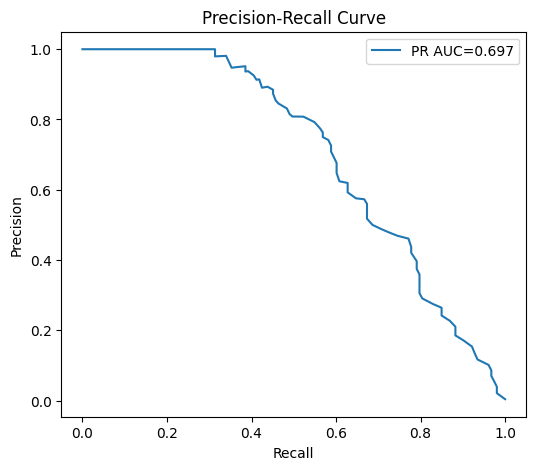

In [5]:
fpr, tpr, _ = roc_curve(y_test, best_proba)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, best_proba)
pr_auc = auc(rec, prec)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR AUC={pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In [6]:
import joblib


joblib.dump(best_model, os.path.join(ARTIFACT_DIR, "model.joblib"))


metrics = {"best_model": best_name, "best_pr_auc": float(best_pr_auc), "target": target}
with open(os.path.join(ARTIFACT_DIR, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved model.joblib and metrics.json to artifacts/")

Saved model.joblib and metrics.json to artifacts/


In [7]:
import json

with open("artifacts/metrics.json") as f:
    metrics = json.load(f)

metrics

{'best_model': 'rf', 'best_pr_auc': 0.693206707667378, 'target': 'is_fraud'}

In [8]:
import joblib

model = joblib.load("artifacts/model.joblib")
model

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
Pipeline(steps=[('pre', ColumnTransformer(...)), ('clf', RandomForestClassifier(...))])

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,Ellipsis
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


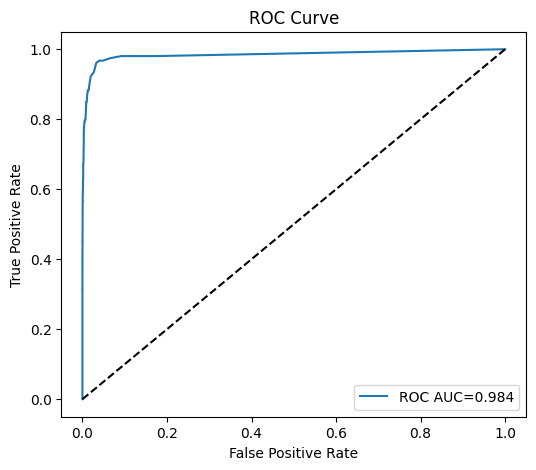

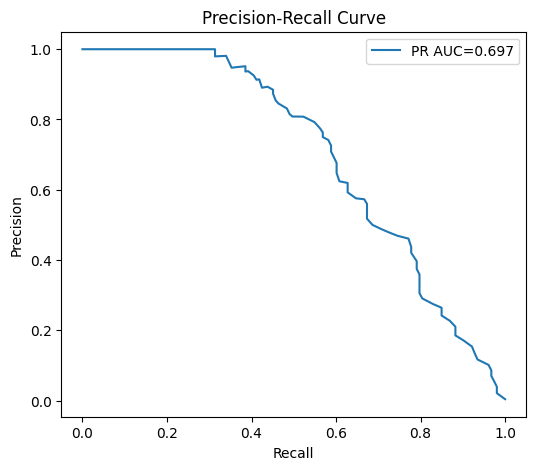

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt


fpr, tpr, _ = roc_curve(y_test, best_proba)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, best_proba)
pr_auc = auc(rec, prec)


plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR AUC={pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

<Figure size 500x500 with 0 Axes>

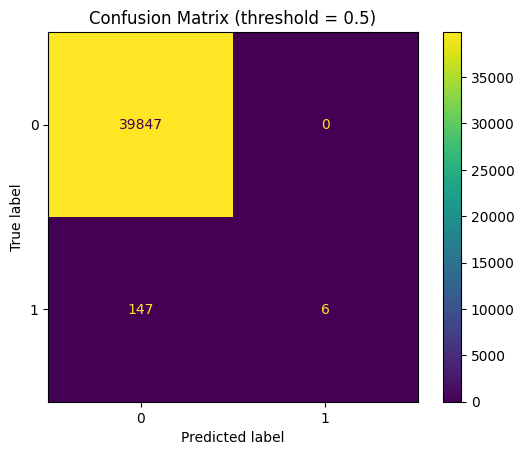

              precision    recall  f1-score   support

           0     0.9963    1.0000    0.9982     39847
           1     1.0000    0.0392    0.0755       153

    accuracy                         0.9963     40000
   macro avg     0.9982    0.5196    0.5368     40000
weighted avg     0.9963    0.9963    0.9946     40000



In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# y_test and best_proba must exist from earlier cells
y_pred_05 = (best_proba >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_05)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig = plt.figure(figsize=(5, 5))
disp.plot(values_format="d")
plt.title("Confusion Matrix (threshold = 0.5)")
plt.show()

print(classification_report(y_test, y_pred_05, digits=4, zero_division=0))

Best-F1 threshold: 0.137
Threshold for ≥90% precision: 0.197


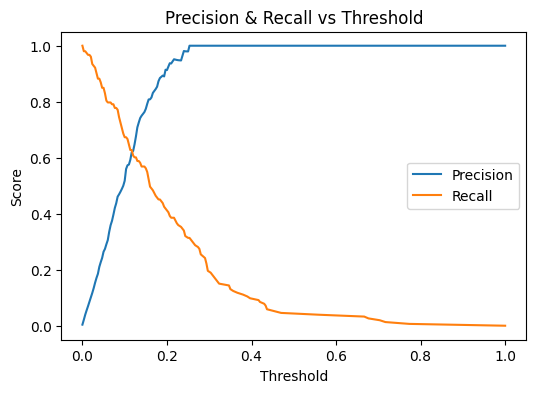

<Figure size 500x500 with 0 Axes>

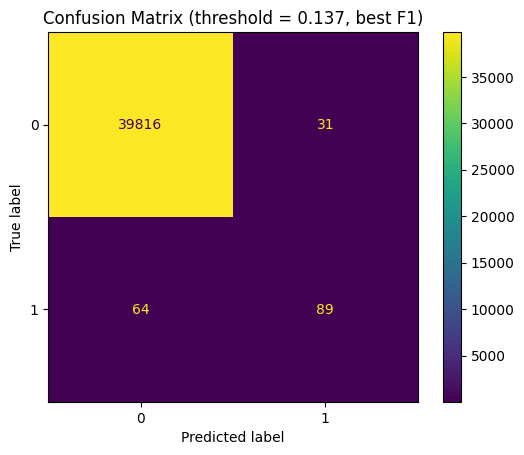

Report @ best-F1 threshold
              precision    recall  f1-score   support

           0     0.9984    0.9992    0.9988     39847
           1     0.7417    0.5817    0.6520       153

    accuracy                         0.9976     40000
   macro avg     0.8700    0.7905    0.8254     40000
weighted avg     0.9974    0.9976    0.9975     40000



In [12]:
from sklearn.metrics import precision_recall_curve, f1_score

prec, rec, thresh = precision_recall_curve(y_test, best_proba)
# thresholds returned by precision_recall_curve are for proba[:-1]
thresh = np.append(thresh, 1.0)

# Example 1: threshold that maximizes F1
f1s = [f1_score(y_test, (best_proba >= t).astype(int)) for t in thresh]
t_best_f1 = float(thresh[int(np.argmax(f1s))])

# Example 2: threshold that achieves at least 90% precision (if possible)
target_precision = 0.90
t_prec = None
for p, r, t in zip(prec, rec, thresh):
    if p >= target_precision:
        t_prec = float(t)
        break

print(f"Best-F1 threshold: {t_best_f1:.3f}")
if t_prec is not None:
    print(f"Threshold for ≥{int(target_precision*100)}% precision: {t_prec:.3f}")
else:
    print(f"Could not reach {int(target_precision*100)}% precision with this model.")

# Plot precision/recall vs threshold
plt.figure(figsize=(6,4))
plt.plot(thresh, prec, label="Precision")
plt.plot(thresh, rec, label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.show()

# Confusion matrix at best-F1 threshold
y_pred_best = (best_proba >= t_best_f1).astype(int)
cm_best = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best)
fig = plt.figure(figsize=(5, 5))
disp.plot(values_format="d")
plt.title(f"Confusion Matrix (threshold = {t_best_f1:.3f}, best F1)")
plt.show()

print("Report @ best-F1 threshold")
print(classification_report(y_test, y_pred_best, digits=4, zero_division=0))

## Conclusion

- **Dataset:** Kaggle Fraud Detection (transactions with `is_fraud` label)
- **Models tried:** Logistic Regression, Random Forest (with/without SMOTE)
- **Best model:** `<MODEL_NAME>`  
- **Scores:**  
  - **ROC-AUC:** `<value>`  
  - **PR-AUC:** `<value>` (primary metric due to class imbalance)

**Interpretation:**
- The model achieves strong separation (high ROC-AUC).  
- PR-AUC indicates good performance on the rare fraud class.  
- At threshold **0.5**, Precision=`<p0.5>`, Recall=`<r0.5>`.  
- Using an optimized threshold **<t_best>**, we get Precision=`<p_opt>`, Recall=`<r_opt>`, which better matches business goals.

**Next steps (if continued):**
- Feature engineering (e.g., time-based features from `trans_date_trans_time`, distance between customer and merchant coords).
- Calibrate probabilities (Platt scaling or isotonic).
- Cost-sensitive tuning based on real business costs of FN vs FP.

## 📊 Approach
- **Preprocessing:** Standardize numeric features, one-hot encode categoricals.
- **Imbalance:** `class_weight='balanced'` + SMOTE variants for comparison.
- **Models:** Logistic Regression, Random Forest.
- **Metrics:** ROC-AUC, **PR-AUC** (primary). Confusion matrices and threshold tuning.

## ▶️ How to run (Notebook)
1. Install deps:
   ```bash
   pip install -r requirements.txt
   # or
   pip install pandas numpy scikit-learn imbalanced-learn matplotlib joblib

In [ ]:
!python3 src/train.py
!python3 src/evaluate.py

logreg: ROC-AUC=0.9684 | PR-AUC=0.3411
